In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import animation
import time
from torch.distributions.categorical import Categorical
import random

In [8]:
N = 102
dx = 1/N
dy = 1/N
dz = 1/N

x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
z = np.linspace(0, 1, N)
X, Y , Z= np.meshgrid(np.linspace(0,1,N, dtype=float),
                   np.linspace(0,1,N, dtype=float),
                   np.linspace(0,1,N, dtype=float))

In [9]:
def mL2V(x, y):
    return np.exp(-(x-0.3)**2/(2*0.1**2))*np.exp(-(y-0.3)**2/(2*0.1**2))

def mL2V(x, y,z):
    return 0*np.exp(-(x-0.3)**2/(2*0.1**2))*np.exp(-(y-0.3)**2/(2*0.1**2))*np.exp(-(z-0.3)**2/(2*0.1**2))
#     if x==0 or y==0 or x==1 or y==1:
#         return 100000000000
     #return -5000000000/(((x-0.5)**2+(y-0.5)**2+(z-0.5)**2)**0.5)


In [10]:
基=np.zeros((len(z),len(y),len(x)), dtype = float, order = 'C')
for k in range(len(z)):
    for j in range(len(y)):
        for i in range(len(x)):
            基[k,j,i]=1/dy**2 +1/dx**2 +1/dz**2 +mL2V(x[i], y[j], z[k])
        
      
    
# 基=基

# d=基.reshape(基.shape[0]*基.shape[1])   

## 编写波函数查询字典

In [11]:
l=0
字典={}
for k in range(N):
    for j in range(N):

        for i in range(N):
            字典[str(k)+'_'+str(j)+'_'+str(i)]=l
            l+=1

        

In [12]:
T=np.zeros(((N-2)**3,1,7))
P=np.zeros(((N-2)**3,7))
l=0
for k in range(1,N-1,1):
    for j in range(1,N-1,1):
        for i in range(1,N-1,1): 
            T[l,0,0]=-1/(2*dx**2)        
            T[l,0,1]=-1/(2*dy**2)
            T[l,0,2]=-1/(2*dz**2)
            T[l,0,3]=基[k,j,i]
            T[l,0,4]=-1/(2*dx**2)        
            T[l,0,5]=-1/(2*dy**2)
            T[l,0,6]=-1/(2*dz**2)
            P[l,0]=字典[str(k)+'_'+str(j)+'_'+str(i+1)]    
            P[l,1]=字典[str(k)+'_'+str(j+1)+'_'+str(i)]
            P[l,2]=字典[str(k+1)+'_'+str(j)+'_'+str(i)]
            P[l,3]=字典[str(k)+'_'+str(j)+'_'+str(i)]
            P[l,4]=字典[str(k)+'_'+str(j)+'_'+str(i-1)]
            P[l,5]=字典[str(k)+'_'+str(j-1)+'_'+str(i)]
            P[l,6]=字典[str(k-1)+'_'+str(j)+'_'+str(i)]
            l+=1

T=torch.Tensor(T) 
P=torch.Tensor(P).to(torch.long)        
        
        
        

In [13]:
#定义神经网络
class 三维薛定谔方程(nn.Module):
    def __init__(self,分割尺寸):
        super().__init__()
        self.波函数 = nn.Parameter(torch.FloatTensor(np.random.uniform(-1, 1, (分割尺寸, 2)))*1)
        self.能量 = nn.Parameter(torch.FloatTensor(np.random.uniform(-1, 1, 2))*1)

    def forward(self, 参数,波函数_位置编号):
        波函数_片段=F.embedding(波函数_位置编号, self.波函数)
        #print(参数.shape,波函数_片段.shape)
        x1=torch.matmul (参数,波函数_片段)
        
        #x2=self.波函数.相乘(self.能量 )
        波函数_片段2=F.embedding(波函数_位置编号[:,3], self.波函数)
        x2= self.能量*波函数_片段2
        #print(x1.shape,x2.shape)
        差值=x2.reshape(x2.shape[0],1,x2.shape[1])-x1
        return  差值
  

In [15]:
三维薛定谔方程实例=三维薛定谔方程(N**3).cuda()
#一维无限深势阱薛定谔方程实例=一维无限深势阱薛定谔方程实例.cuda()
#parameters = 一维无限深势阱薛定谔方程实例.parameters()
优化函数 = torch.optim.Adam(三维薛定谔方程实例.parameters(), betas=(0.9, 0.95), eps=1e-9)
目标输出=torch.Tensor(np.zeros(((N-2)**3,1,2))).cuda()
print(目标输出.shape)
for i in range(2500):
    差值=三维薛定谔方程实例(T.cuda()/12000,P.cuda())

    优化函数.zero_grad()
    #print(差值.shape,目标输出.shape)
    loss=F.mse_loss(差值,目标输出)

    if (i +1)%100==0:
        
        print(差值[0,0],loss)
    loss.backward()

    优化函数.step()

torch.Size([1000000, 1, 2])
tensor([-2.1853, -0.7523], device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.9598, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([-1.6908, -0.4487], device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.5689, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([-1.2213, -0.2151], device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3165, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([-0.7935, -0.0390], device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1629, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([-0.4517,  0.0179], device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0762, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([-0.1721,  0.0214], device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0318, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([-0.0337,  0.0028], device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([-0.0020, -0.0010], device='cuda:0', grad_fn=<Se

In [16]:
parameters = 三维薛定谔方程实例.parameters()
for p in parameters:
    Va=p .detach().cpu().numpy()
    break

In [17]:
np.savez('波函数三维演示.npz', 输出Va=Va)

In [3]:
np文件路径='波函数三维va新0势能万分之一能量20220223.npz'
npz文件=np.load(np文件路径, allow_pickle=True)
Va=npz文件["输出Va"]

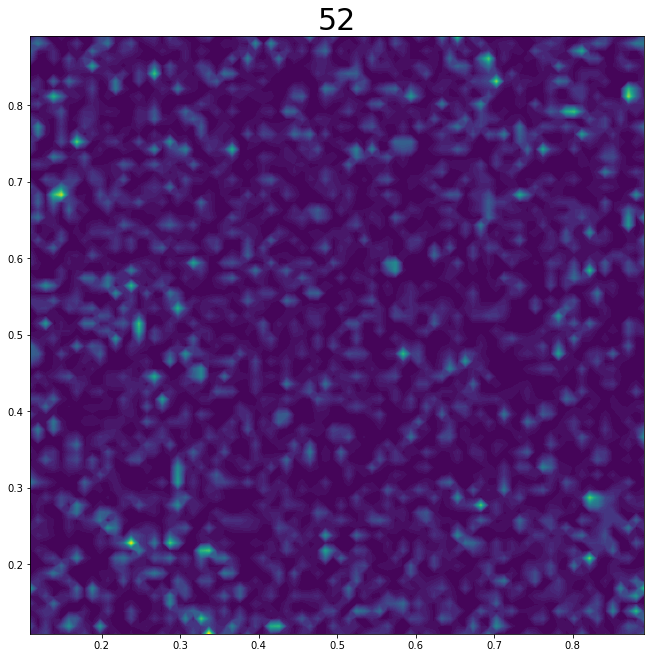

In [19]:
缩=11
def get_e1(n,m):
    return Va[:,n].reshape((N ,N,N))[缩:-缩,缩:-缩,m]
for i in range(52,53,1):
    #plt.plot(y,  get_e2(i))
    plt.figure(figsize=(11,11))
    plt.contourf(y[缩:-缩], x[缩:-缩], get_e1(0,i)**2, 50)
    plt.title('{}'.format(i), fontsize=30)
    #plt.savefig('千分之一初始能量1振幅/0势能{}.png'.format(i))

In [20]:
p=11

X1=np.ones(((N-2*p)**3))
Y1=np.ones(((N-2*p)**3))
Z1=np.ones(((N-2*p)**3))
n=0
for k in range(p,len(z)-p,1):
    for j in range(p,len(y)-p,1):
        for i in range(p,len(x)-p,1):
            X1[n]=x[i]
            Y1[n]=y[j]
            Z1[n]=z[k]
            n+=1
            

In [21]:
def maxminnorm(array):
    maxcols=array.max()

    return array/maxcols

In [22]:
VB=maxminnorm(Va.reshape(N ,N,N,Va.shape[1])[p:-p,p:-p,p:-p,:]**2)


In [23]:
VC=VB.reshape(VB.shape[0]*VB.shape[1]*VB.shape[2],VB.shape[3])

In [24]:

总包=[]
for j in range(VC.shape[1]):
    C小=[]    
    X小=[]
    Y小=[]
    Z小=[]
    C中=[]    
    X中=[]
    Y中=[]
    Z中=[]    
    C大=[]
    X大=[]
    Y大=[]
    Z大=[]
    
    计数=0
    计数1=0
    字典={}
    for i in range(VC.shape[0]):
        if  VC[i,j]>0.06:
            C大.append(VC[i,j])
            X大.append(X1[i])
            Y大.append(Y1[i])
            Z大.append(Z1[i])
            
            计数+=1
        elif 0.06>VC[i,j]>0.03:
            
            C中.append(VC[i,j])
            X中.append(X1[i])
            Y中.append(Y1[i])
            Z中.append(Z1[i]) 
            计数1+=1
        else:
            C小.append(VC[i,j])
            X小.append(X1[i])
            Y小.append(Y1[i])
            Z小.append(Z1[i])
    
            
            
        
    字典["C大"]=C大
    字典["X大"]=X大
    字典["Y大"]=Y大
    字典["Z大"]=Z大
    
    字典["C中"]=C中
    字典["X中"]=X中
    字典["Y中"]=Y中
    字典["Z中"]=Z中
    
    字典["C小"]=C小
    字典["X小"]=X小
    字典["Y小"]=Y小
    字典["Z小"]=Z小
    总包.append(字典.copy())
    print(计数,计数1)

    

98963 82935
92547 82451


0.14567995071411133


<Figure size 1296x1296 with 0 Axes>

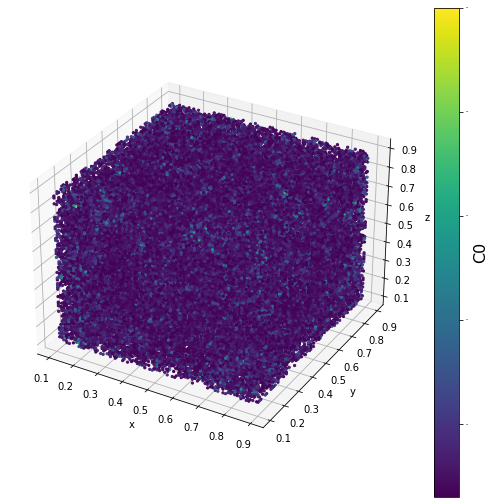

1.4759430885314941


In [30]:
#ax = fig.add_subplot(111, projection='3d')
plt.figure(figsize=(18,18))
fig = plt.figure()  #创建一个图
ax = fig.add_subplot(111, projection='3d')
cm = plt.cm.get_cmap('jet')  #颜色映射，为jet型映射规则
time_a=time.time()

fig = ax.scatter3D(总包[0]["X大"], 总包[0]["Y大"], 总包[0]["Z大"] , c = 总包[0]["C大"] ,marker='.',alpha=1)
#fig = ax.scatter3D(总包[0]["X中"], 总包[0]["Y中"], 总包[0]["Z中"] , c = 总包[0]["C中"] ,marker='.',alpha=1)
#fig = ax.scatter3D(总包[0]["X小"], 总包[0]["Y小"], 总包[0]["Z小"] , c = 总包[0]["C小"] ,marker='.',alpha=0.01)

print(time.time()-time_a)
cb = plt.colorbar(fig)  #设置坐标轴
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cb.ax.tick_params(labelsize=2)
cb.set_label('C0', size = 16)



plt.rcParams['figure.figsize'] = (9.0, 9.0)

plt.show()
print(time.time()-time_a)

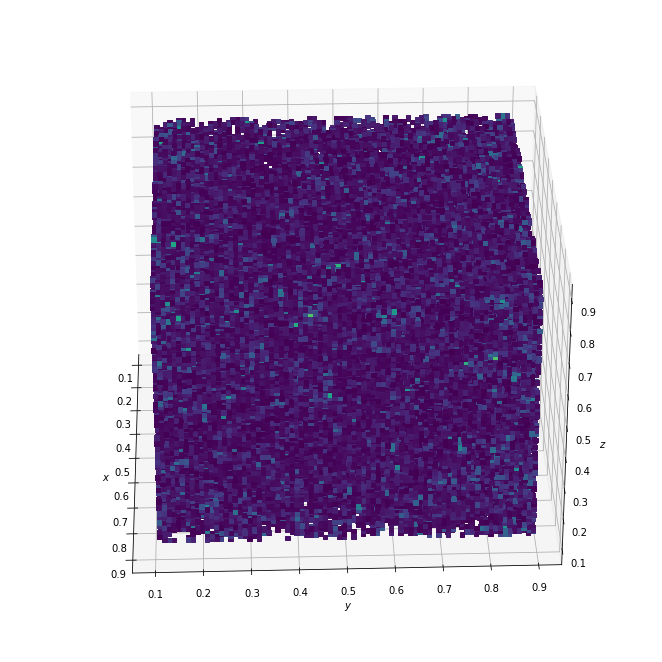

In [31]:
my_cmap = plt.get_cmap('cool')
def init():
    # Plot the surface.
    #ax.scatter3D(总包[0]["X大"], 总包[0]["Y大"], 总包[0]["Z大"] , c = 总包[0]["C大"] ,marker='.',alpha=1)
    ax.scatter3D(总包[0]["X大"], 总包[0]["Y大"], 总包[0]["Z大"] , c = 总包[0]["C大"] ,marker=',',alpha=1)
    #ax.scatter3D(总包[0]["X中"], 总包[0]["Y中"], 总包[0]["Z中"] , c = 总包[0]["C中"] ,marker=',',alpha=0.1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    return fig,

def animate(i):
    ax.view_init(elev=30, azim=2*i)
    return fig,
plt.rcParams['figure.figsize'] = (9.0, 9.0)
fig = plt.figure()
ax = Axes3D(fig)
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=180, interval=30)
ani.save('video演示test.mp4', writer='ffmpeg',fps=30)
#ani.save('rotate_azim1321.gif',writer='pillow',fps=20)